# Try implementation of resonance fill factors

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

Start by loading the training data generated with generate_FC_data.ipynb

In [2]:
#load datapath for clean training data that is generated
datapath = '../../cleanData/csvs/resonant/'

dataset = pd.read_csv(datapath+'25-3-25-fillFac.csv')
#remove junk columns
dataset = dataset.drop(columns=['Unnamed: 0','Unnamed: 0.1'])

We can then split the data into training and testing sets, note, we will remove systems that go unstable in 1e4 orbits from the testing set

In [3]:
def train_test(dataset,features):
    '''divides the dataset into 80% training and 20% testing and returns training/testing sets'''
    Nrows = int(0.8*dataset.shape[0])
    train = dataset.iloc[:Nrows, :]
    test = dataset.iloc[Nrows:, :]
    #remove testing systems that go unstable in short integration phase

    test = test.drop(test[test['InitialStable']==False].index)
    return train[features], train['Stable'], test[features], test['Stable'], test['instability_time']

We can then define the features of interest and dividing training and testing sets

In [4]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno + ['Tsec', '3BRfill', '2BRfillnear', '2BRfillfar']

trainX, trainY, testX, testY, testInstability = train_test(dataset, features)

**Define some helper functions**

In [5]:
from sklearn import metrics
from sklearn.metrics import roc_curve, confusion_matrix, auc
def ROC_curve( model, x,y):
    preds = model.predict_proba(x)[:,1]
    fpr, tpr, ROCthresholds = roc_curve(y, preds)
    roc_auc = metrics.roc_auc_score(y, preds)
    return roc_auc, fpr, tpr, ROCthresholds

The below function gets performance when excluding the given columns from training / testing

In [12]:
def getPreformance( label, exclude, trainX=trainX, trainY=trainY, testX=testX, testY=testY):
    model = XGBClassifier(learning_rate = 0.05, 
                         max_depth = 13, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 100,
                         )
    model.fit(trainX.drop(columns=exclude),trainY.drop(columns=exclude))

    roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX.drop(columns=exclude), testY.drop(columns=exclude))

    tprthreshindex = np.where(tpr >=0.9)[0][0]
    falsePos = fpr[tprthreshindex]

    return label, roc_auc, falsePos

**We can now collect the AUC of a model using each permutation of new features**
Note, FPR (false positive rate) is evaluated when TPR is 0.9

In [17]:
results = np.array([getPreformance('Old features', ['3BRfill','2BRfillnear','2BRfillfar']),
getPreformance('Old features + 3BRfill', ['2BRfillnear','2BRfillfar']),
getPreformance('Old features +2BRfill', ['3BRfill']),
getPreformance('all features', []),
])

In [18]:
displayResults = pd.DataFrame(results, columns = ['Model comparisons', 'AUC', 'FPR'])

# We can now note the ablation study

In [19]:
displayResults.sort_values(by='AUC', ascending=True, inplace=False)

,Model comparisons,AUC,FPR
0,Old features,0.9502022027554688,0.14312539119549342
1,Old features + 3BRfill,0.9507076244696655,0.1436122122539815
2,Old features +2BRfill,0.9552601240810165,0.13178941511927117
3,all features,0.9563403394015109,0.13018986021281034


**We can check the feature importance for the model using all features, while also using a more complex model**

In [23]:
model = XGBClassifier(learning_rate = 0.05, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 150,
                         )
model.fit(trainX,trainY)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

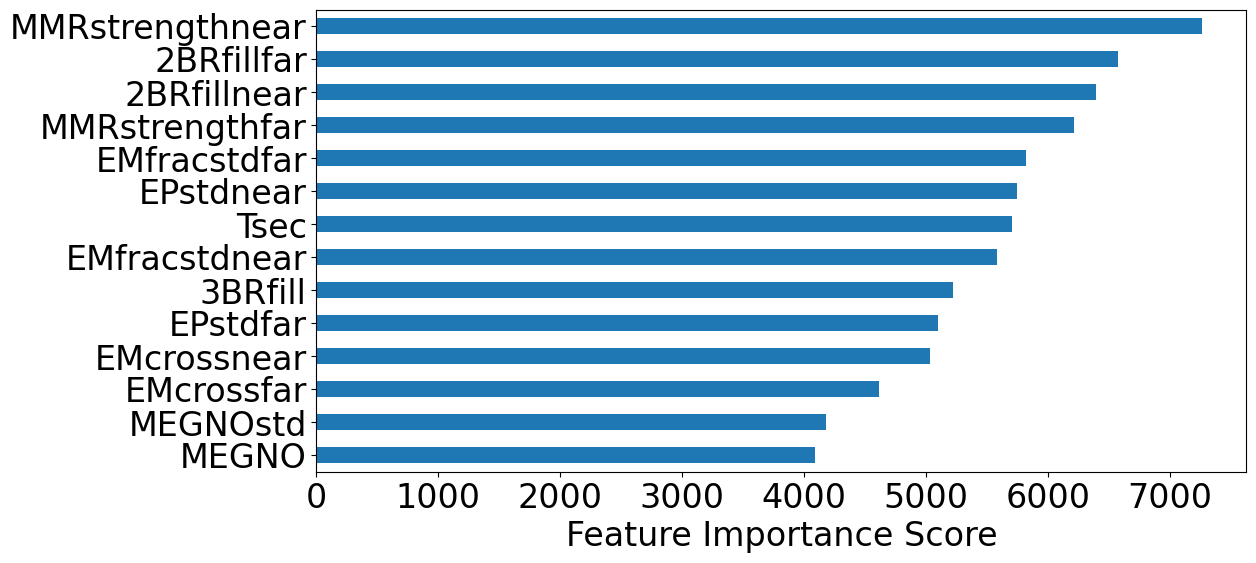

In [25]:
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,6), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()

Text(0.5, 1.0, '(AUC = 0.9578)')

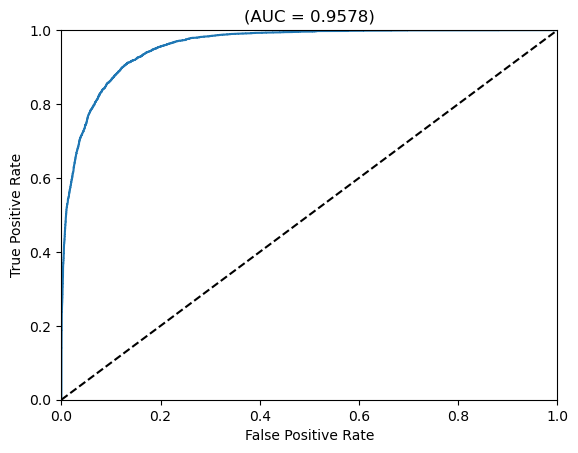

In [29]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX, testY)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('(AUC = {0:.4f})'.format(roc_auc))


In [28]:
roc_auc

0.9578077542639684